## Importing Necessary libraries

In [0]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

## Opening the training files using pickle and loading them as list.

In [0]:
with open('train_image.pkl','rb') as f:
  X = pickle.load(f)

with open('train_label.pkl','rb') as f:
  Y = pickle.load(f)

## 'X' and 'Y' are of type "List"

In [0]:
print(type(X))
print(type(Y))

<class 'list'>
<class 'list'>


## Converting the lists to Arrays

In [0]:
X = np.array(X)
Y = np.array(Y)

print(type(X))
print(type(Y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Displaying an Image data point from training DataSet

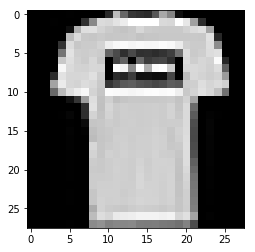

In [0]:
img = X[0,:].reshape(28,28)
plt.grid(False)
plt.imshow(img,cmap = "gray")


## The Classes for images are "0" , "2" , "3" , "6" and each class has 2000 instances, thus our Dataset is Balanced.

In [0]:
print(np.unique(Y,return_counts = True))

(array([0, 2, 3, 6]), array([2000, 2000, 2000, 2000]))


## Changing Label of images to continuous numbers

We've to change the labels of images from [0,2,3,6] to [0,1,2,3] because if we don't change it then it'll cause problem in computing Loss for our Model and that's because we've got only 4 classes and the last class has number 6 and during computation, it checks whether **class number** is greater than the **total number of classes** or not (Here, 6 which is class number will be greater than 4 which is total number of classes). Thus, for that matter error will occur.

In [0]:
Y[Y == 2] = 1
Y[Y == 3] = 2
Y[Y == 6] = 3

In [0]:
print(np.unique(Y,return_counts = True))

(array([0, 1, 2, 3]), array([2000, 2000, 2000, 2000]))


In [0]:
print(X.shape)
print(Y.shape)

(8000, 784)
(8000,)


We can see that our data is **NOT** randomly distributed. 

First 2000 images belong to class 0. 

From 2000 - 4000 images belong to class 1.

From 4000 - 6000 images belong to class 2.

From 6000 - 8000 images belong to class 3.

In [0]:
print(np.unique(Y[:2000],return_counts = True))
print(np.unique(Y[2000:4000],return_counts = True))
print(np.unique(Y[4000:6000],return_counts = True))
print(np.unique(Y[6000:8000],return_counts = True))

(array([0]), array([2000]))
(array([1]), array([2000]))
(array([2]), array([2000]))
(array([3]), array([2000]))


## We concatenate 'X' and 'Y'

We concatenate 'X' and 'Y' because, we've to shuffle the final array formed to make data randomly distributed. If data is not randomly distributed then our model can give biased results, which we don't want.

In [0]:
data = np.concatenate((X,Y[:,None]) , axis = 1)

In [0]:
print(np.unique(data[:,-1],return_counts = True))
df = pd.DataFrame(data)
print(np.unique(df.iloc[:,-1],return_counts = True))


(array([0, 1, 2, 3]), array([2000, 2000, 2000, 2000]))
(array([0, 1, 2, 3]), array([2000, 2000, 2000, 2000]))


## Shuffling of Data

In [0]:
df = df.sample(frac = 1).reset_index(drop = True)
print(np.unique(df.iloc[:,-1],return_counts = True))

(array([0, 1, 2, 3]), array([2000, 2000, 2000, 2000]))


In [0]:
data = df.values
print(type(data))

<class 'numpy.ndarray'>


## Checking first 100 labels of our data

In [0]:
data[:100,-1]

array([0, 2, 0, 3, 2, 3, 0, 3, 1, 0, 3, 0, 1, 1, 2, 1, 0, 3, 3, 3, 2, 1,
       3, 0, 3, 3, 1, 3, 1, 3, 3, 3, 0, 1, 1, 2, 1, 1, 3, 2, 3, 2, 3, 3,
       0, 1, 2, 1, 3, 3, 2, 2, 3, 0, 3, 2, 1, 1, 0, 2, 0, 0, 0, 2, 2, 2,
       3, 1, 1, 3, 0, 2, 2, 1, 2, 2, 0, 0, 0, 2, 1, 3, 3, 0, 0, 1, 1, 2,
       2, 2, 1, 0, 2, 3, 2, 0, 0, 3, 2, 0])

## Data Preparation

In [0]:
X_train = data[:7000,:784] / 255.0
Y_train = data[:7000,-1]

X_val = data[7000:,:784] / 255.0
Y_val = data[7000:,-1]

print(X_train.shape, Y_train.shape)

(7000, 784) (7000,)


## Checking that each Training and Validation set contain all the classes

In [0]:
print(np.unique(Y_train))
print(np.unique(Y_val))

[0 1 2 3]
[0 1 2 3]


## Building Model

In [0]:
class Net(torch.nn.Module):
    def __init__(self,n_feature,hidden_01,hidden_02,hidden_03,n_output):
        super(Net,self).__init__()
        self.hidden_01 = torch.nn.Linear(n_feature,hidden_01)
        self.hidden_02 = torch.nn.Linear(hidden_01,hidden_02)
        self.hidden_03 = torch.nn.Linear(hidden_02,hidden_03)
        self.n_output = torch.nn.Linear(hidden_03,n_output)
        
    def forward(self,x):
        x = F.relu(self.hidden_01(x))
        x = F.relu(self.hidden_02(x))
        x = F.relu(self.hidden_03(x))
        x = F.log_softmax(self.n_output(x))
        return x

## Our Model is a Neural Net with structure:

784 --> 300 --> 100 --> 16 --> 4

In [0]:
net = Net(n_feature = 784, hidden_01 = 300, hidden_02 = 100, hidden_03 = 16,n_output = 4)
print(net)

#optimizer = torch.optim.Adam(net.parameters(),lr=0.1)
loss_func = torch.nn.CrossEntropyLoss()

Net(
  (hidden_01): Linear(in_features=784, out_features=300, bias=True)
  (hidden_02): Linear(in_features=300, out_features=100, bias=True)
  (hidden_03): Linear(in_features=100, out_features=16, bias=True)
  (n_output): Linear(in_features=16, out_features=4, bias=True)
)


## Adam Optimizer is used with Learning Rate of 0.001

In [0]:
opt=torch.optim.Adam(net.parameters(),lr=0.001)

## Converting Training data to Tensors

In [0]:
X1 = torch.tensor(X_train).type(torch.FloatTensor)
Y1 = torch.tensor(Y_train).type(torch.FloatTensor)

print(X1.dtype)
print(Y1.dtype)

torch.float32
torch.float32


## Converting Training Tensors to Variables

In [0]:
X_train = Variable(X1, requires_grad=True).type(torch.FloatTensor)
Y_train = Variable(Y1, requires_grad=False).type(torch.LongTensor)

print(X_train.dtype)
print(Y_train.dtype)
print(Y_train.shape)

torch.float32
torch.int64
torch.Size([7000])


## Training our Model on Training Data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


tensor(1.3956, grad_fn=<NllLossBackward>)
tensor(1.3826, grad_fn=<NllLossBackward>)
tensor(1.3618, grad_fn=<NllLossBackward>)
tensor(1.3350, grad_fn=<NllLossBackward>)
tensor(1.3010, grad_fn=<NllLossBackward>)
tensor(1.2611, grad_fn=<NllLossBackward>)
tensor(1.2188, grad_fn=<NllLossBackward>)
tensor(1.1739, grad_fn=<NllLossBackward>)
tensor(1.1281, grad_fn=<NllLossBackward>)
tensor(1.0831, grad_fn=<NllLossBackward>)
tensor(1.0373, grad_fn=<NllLossBackward>)
tensor(0.9954, grad_fn=<NllLossBackward>)
tensor(0.9559, grad_fn=<NllLossBackward>)
tensor(0.9190, grad_fn=<NllLossBackward>)
tensor(0.8864, grad_fn=<NllLossBackward>)
tensor(0.8565, grad_fn=<NllLossBackward>)
tensor(0.8308, grad_fn=<NllLossBackward>)
tensor(0.8072, grad_fn=<NllLossBackward>)
tensor(0.7862, grad_fn=<NllLossBackward>)
tensor(0.7678, grad_fn=<NllLossBackward>)
tensor(0.7528, grad_fn=<NllLossBackward>)
tensor(0.7383, grad_fn=<NllLossBackward>)
tensor(0.7268, grad_fn=<NllLossBackward>)
tensor(0.7155, grad_fn=<NllLossBac

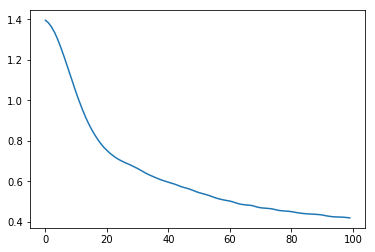

In [0]:
err = []

for ix in range(100):
    
    out = net(X_train)
    loss = loss_func(out,Y_train)
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    err.append(loss)
    print(loss)
    
plt.plot(err[:])

## Printing the Least Error while training

In [0]:
print(err[-1])

tensor(0.4190, grad_fn=<NllLossBackward>)


## Converting Validation Data into Tensor then Variable

In [0]:
X_val = torch.Tensor(X_val)
X_val = Variable(X_val, requires_grad = True).type(torch.FloatTensor)

## Testing our Model using Validation Dataset

In [0]:
out_val = net(X_val)

print(type(out_val))

<class 'torch.Tensor'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


## Selecting the class with highest Probability, as that would be our Final Prediction

In [0]:
out_final = out_val.data.numpy().argmax(axis=1)

print(out_final.shape)
print(out_final[:10])

(1000,)
[2 0 2 2 1 0 2 0 1 2]


## Getting Accuracy on Validation Dataset

In [0]:
acc = ((out_final == Y_val).sum()/ (X_val.shape[0])) * 100

## Printing Accuracy

In [0]:
print(acc)

81.0


## Opening The Testing File in Read Mode and loading the Data in to "test" file

In [0]:
with open('test_image.pkl','rb') as f:
  test = pickle.load(f)

type(test)

list

## Converting list "test" to Array

In [0]:
test_dataset = np.array(test)
print(type(test_dataset))

<class 'numpy.ndarray'>


In [0]:
print(test_dataset.shape)

(2000, 784)


## Normalizing Test Dataset and converting it to Tensor and then to Variable

In [0]:
test_ds = test_dataset[:,:] / 255.0

test_ds = torch.Tensor(test_ds)
test_ds = Variable(test_ds, requires_grad = True).type(torch.FloatTensor)

print(type(test_ds))

<class 'torch.Tensor'>


## Passing our Test Dataset to Model and storing output in "out_test"

In [0]:
out_test = net(test_ds)

print(type(out_test))

<class 'torch.Tensor'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


## Selecting the class with highest Probability, as that would be our Final Prediction

In [0]:
out_final = out_test.data.numpy().argmax(axis=1)

print(out_final.shape)
print(out_final[:100])

(2000,)
[0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 3 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 2 0 0
 3 0 0 3 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 2 2 0 0 2 2 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 3 0 2 2 0 0 0 0 3 3 3]


In [0]:
print(type(out_final))
print(np.unique(out_final, return_counts = True))

<class 'numpy.ndarray'>
(array([0, 1, 2, 3]), array([485, 496, 514, 505]))


## Converting labels back to their original form i.e., from [0,1,2,3] to [0,2,3,6]

In [0]:
for ix in range(2000):
  if out_final[ix] == 1:
    out_final[ix] = 2
    
  elif out_final[ix] == 2:
    out_final[ix] = 3
    
  elif out_final[ix] == 3:
    out_final[ix] = 6

In [0]:
print(np.unique(out_final,return_counts = True))

(array([0, 2, 3, 6]), array([485, 496, 514, 505]))


In [0]:
print(out_final[:1000])

[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 6 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 3 0 0
 6 0 0 6 0 0 0 0 0 6 2 0 0 0 0 0 0 0 0 3 3 0 0 3 3 0 0 3 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 6 0 3 3 0 0 0 0 6 6 6 0 6 0 0 0 6 0 0 2 0 0
 0 0 0 3 2 6 0 0 0 0 6 0 0 3 6 3 0 0 0 0 6 0 0 0 6 0 0 6 0 0 0 3 0 0 0 0 0
 0 0 6 0 6 3 0 0 0 0 0 0 6 0 0 0 0 0 6 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 6 0 6 0 6 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 6 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 6 0 6 6 0 0 0 0
 6 0 0 0 0 6 6 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 2 6 0 0 0 2
 0 0 0 0 0 3 0 0 0 0 6 0 0 0 0 3 0 6 0 0 0 0 3 3 0 0 6 6 0 0 0 0 0 0 0 0 0
 0 0 0 0 6 0 6 0 0 0 0 0 0 0 6 0 0 6 0 0 0 0 0 3 3 6 0 3 3 0 6 0 0 0 6 0 0
 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 6 0 2 6 0 0 0
 0 0 0 0 0 0 0 0 0 6 0 0 6 0 0 0 0 0 2 3 0 0 0 6 0 0 0 6 0 6 0 3 3 0 0 0 0
 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 6 0 0 0 3 0 0 0 6 3 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [0]:
out_final = pd.DataFrame(out_final)
print(type(out_final))
print(out_final.shape)

<class 'pandas.core.frame.DataFrame'>
(2000, 1)


In [0]:
out_final.to_csv('./Ayush_Kumar_Tripathi.csv',header = True, index = False)